In [1]:
import pandas as pd
import numpy as np

import pymc as pm
from pymc import HalfCauchy, Model, Normal, model_to_graphviz

import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import gmean
from scipy.stats import norm
from scipy import special
from scipy.optimize import curve_fit
from scipy.special import expit
from scipy.optimize import fsolve

#import NDL
%run NDL.ipynb

In [2]:
# Paramètres clés
VLE = 100 # Exposure limit
RISK_THRESHOLD = 0.3  # 30% Overexposure risk threshold
FRACTION_LIMIT = 0.05  # 5% Exceedance threshold
ICC_THRESHOLD = 0.2 #Within-worker correlation threshold
CIP=0.9 #Credible interval probability

In [3]:
# Charge les données
# dataNDL.csv: sans valeurs censurées, data.csv: avec valeurs censurées ( <0.01 et [0.01-0.033])  
df = pd.read_csv("data.csv", delimiter=";") 
# Colonnes attendues : Value, Sensor, Volume
df = df.dropna(subset=['Value'])

# CONFIG

In [4]:
class Config:
    def __init__(self, chemin_csv="data.csv", VLE=1.0, seuil_risque=0.30, limite_fd=0.05, CIP=0.9, seuil_icc=0.20,
                 draws=1000, tune=500, chains=2, target_accept=0.9, random_seed=42):
        self.chemin_csv = chemin_csv
        self.VLE = VLE
        self.seuil_risque = seuil_risque #seuil de reisque de surexposition
        self.limite_fd = limite_fd #fraction de depassement
        self.CIP = CIP #intervalle de credibilité
        self.seuil_icc = seuil_icc #correlation inter travailleur
        self.draws = draws
        self.tune = tune
        self.chains = chains
        self.target_accept = target_accept
        self.random_seed = random_seed

## Fonctions

In [5]:
def charger_et_transformer(cfg: Config) -> pd.DataFrame:
    
    df = pd.read_csv(cfg.chemin_csv, delimiter=";") 
    attendues = {"Value", "Sensor", "Volume"}
    manquantes = attendues - set(df.columns)
    if manquantes:
        raise ValueError(f"Colonnes manquantes dans le CSV: {sorted(manquantes)}")
        
    df = CheckNDL(df) #df.copy()     
    df["ratio"] = df["ValueNDL"] / float(cfg.VLE)
    df["log_ratio"] = np.log(df["ratio"])
   
    df["Sensor"] = df["Sensor"].astype(str)
    cat = pd.Categorical(df["Sensor"])
    df["sensor_id"] = cat.codes
    df.attrs["sensor_categories"] = list(cat.categories)
    return df

In [6]:
def ajuster_modele(df: pd.DataFrame, cfg: Config):
    sensor_idx = df["sensor_id"].to_numpy()
    n_sensors = int(df["sensor_id"].nunique())

    y_obs = df["log_ratio"].to_numpy()
    upper = np.where(df['NDL'], df['log_ratio'].to_numpy(), np.inf)
    lower = np.full_like(upper, -np.inf, dtype=float)  
    
    a_sd = 1.05 # sigma within  
    b_sd = 10 # sigma within      
    # Calculs empiriques sur l'échelle log(Value/VLE)
    mean_log = df['log_ratio'].mean()
    sd_log = df['log_ratio'].std(ddof=1)
    sensor_means = df.groupby('sensor_id')['log_ratio'].mean()
    between_sd = sensor_means.std(ddof=1)    
    # Bornes pour mu : moyenne ± k * sd (k large pour rester peu-informatif mais centré)
    k_mu = 10.0
    mu_lower =  float(mean_log - k_mu * sd_log)
    mu_upper =  float(mean_log + k_mu * sd_log)    
    
    with pm.Model() as model:
        # Priors uniformes
        mu = pm.Uniform("mu", lower=mu_lower, upper=mu_upper)
        sd_b = pm.Uniform("sd_b", lower=a_sd, upper=b_sd)    # sigma between  
        sd_w = pm.Uniform("sd_w", lower=a_sd, upper=b_sd)   # sigma within  
        
        # Effets aléatoires par sonde
        #a = pm.Normal("a", mu=0.0, sigma=sd_b, shape=n_sensors)
        u = pm.Normal("u", mu=0, sigma=1, shape=n_sensors)
        a = pm.Deterministic("ar", u  * sd_b)         
        
        # Espérance par observation
        mu_i = mu + a[sensor_idx]

        base = pm.Normal.dist(mu=mu_i, sigma=sd_w)
        obs = pm.Censored('obs', base, lower=lower, upper=upper, observed=y_obs)        
        #pm.Normal("obs", mu=mu_i, sigma=sd_w, observed=y_obs)
        
        sd_tot = pm.Deterministic("sd_tot", pt.sqrt(sd_b**2 + sd_w**2))
        icc = pm.Deterministic("ICC", (sd_b**2) / (sd_b**2 + sd_w**2 + 1e-12))
        z = (0.0 - mu) / (sd_tot + 1e-12)
        frac_dep = pm.Deterministic("fraction_depassement", 1.0 - pm.math.invprobit(z * pt.sqrt(2)))
        GM = pm.Deterministic("GM", pt.exp(mu))
        GSD = pm.Deterministic("GSD", pt.exp(sd_tot))
        _ = pm.Deterministic("Pr_fd_gt_lim", frac_dep > cfg.limite_fd)
        _ = pm.Deterministic("Pr_ICC_gt_seuil", icc > cfg.seuil_icc)
        idata = pm.sample(draws=cfg.draws, tune=cfg.tune, chains=cfg.chains, random_seed=cfg.random_seed,
                          target_accept=cfg.target_accept, return_inferencedata=True, cores=None)
    return idata

In [7]:
def resumer(idata: az.InferenceData):
    post = idata.posterior
    def flat(name):
        return post[name].values.reshape(-1)
    out = {}
    for n in ["mu","sd_b","sd_w","sd_tot","ICC","GM","GSD","fraction_depassement"]:
        arr = flat(n)
        med = np.median(arr)
        lo, hi = az.hdi(arr, hdi_prob=0.95) 
        out[n] = {"median":float(med),"hdi_low":float(lo),"hdi_high":float(hi)}
        
    out["prob_fd_gt_lim"] = float(flat("Pr_fd_gt_lim").mean())
    out["prob_ICC_gt_seuil"] = float(flat("Pr_ICC_gt_seuil").mean())


    lo5, hi5 = az.hdi(flat("fraction_depassement"), hdi_prob=0.5)
    out["lo5"] = lo5
    out["hi5"] = hi5
    
    mu =flat("mu")
    sd_tot = flat("sd_tot")
    pl=1-lo5
    ql = np.exp(mu + norm.ppf(pl) * sd_tot)  
    out["VLE_lo"] = np.median(ql)

    ph=1-hi5
    qh = np.exp(mu + norm.ppf(ph) * sd_tot)    
    out["VLE_hi"] = np.median(qh)
    
    return out


In [8]:
def balayage_vle(chemin_csv="mesures.csv", vles=range(1,101,10), multiple=10):
    resultats = []
    for vle in vles:
        vlem = vle*multiple
        cfg = Config(chemin_csv=chemin_csv, VLE=vlem, draws=500, tune=300, chains=2)
        print(f"--- VLE = {vlem} ---")
        try:
            df = charger_et_transformer(cfg)
            idata = ajuster_modele(df, cfg)
            summary = resumer(idata)
            resultats.append({"VLE":vlem, "risque_surexposition":summary["prob_fd_gt_lim"], "VLE_lo":summary["VLE_lo"], "VLE_lo":summary["VLE_hi"] })
        except Exception as e:
            print(f"Erreur VLE={vlem}: {e}")
            resultats.append({"VLE":vlem, "risque_surexposition":np.nan})
    df_res = pd.DataFrame(resultats)
    return df_res

In [ ]:
resultats = []
vlem=58.694449
cfg = Config(chemin_csv="dataNDL.csv", VLE=vlem, draws=500, tune=300, chains=4)
print(f"--- VLE = {vlem} ---")
try:
    df = charger_et_transformer(cfg)
    idata = ajuster_modele(df, cfg)
    summary = resumer(idata)
    resultats.append({"VLE":vlem, "risque_surexposition":summary["prob_fd_gt_lim"], "VLE_lo":summary["VLE_lo"], "VLE_hi":summary["VLE_hi"] })
except Exception as e:
    print(f"Erreur VLE={vlem}: {e}")
    resultats.append({"VLE":vlem, "risque_surexposition":np.nan})
df_res = pd.DataFrame(resultats)

--- VLE = 58.694449 ---


Initializing NUTS using jitter+adapt_diag...


In [ ]:
summary = resumer(idata)
print(summary)

In [ ]:
def percentile_deterministic(mu, sd_tot, p=0.97):
    z = norm.ppf(p)
    return np.exp(mu + z * sd_tot)

0.9999939415835999
0.9737855846481878

0.324
-4.298493181749397
3.1235245225629464

11712.48079546759
5.811750923169474


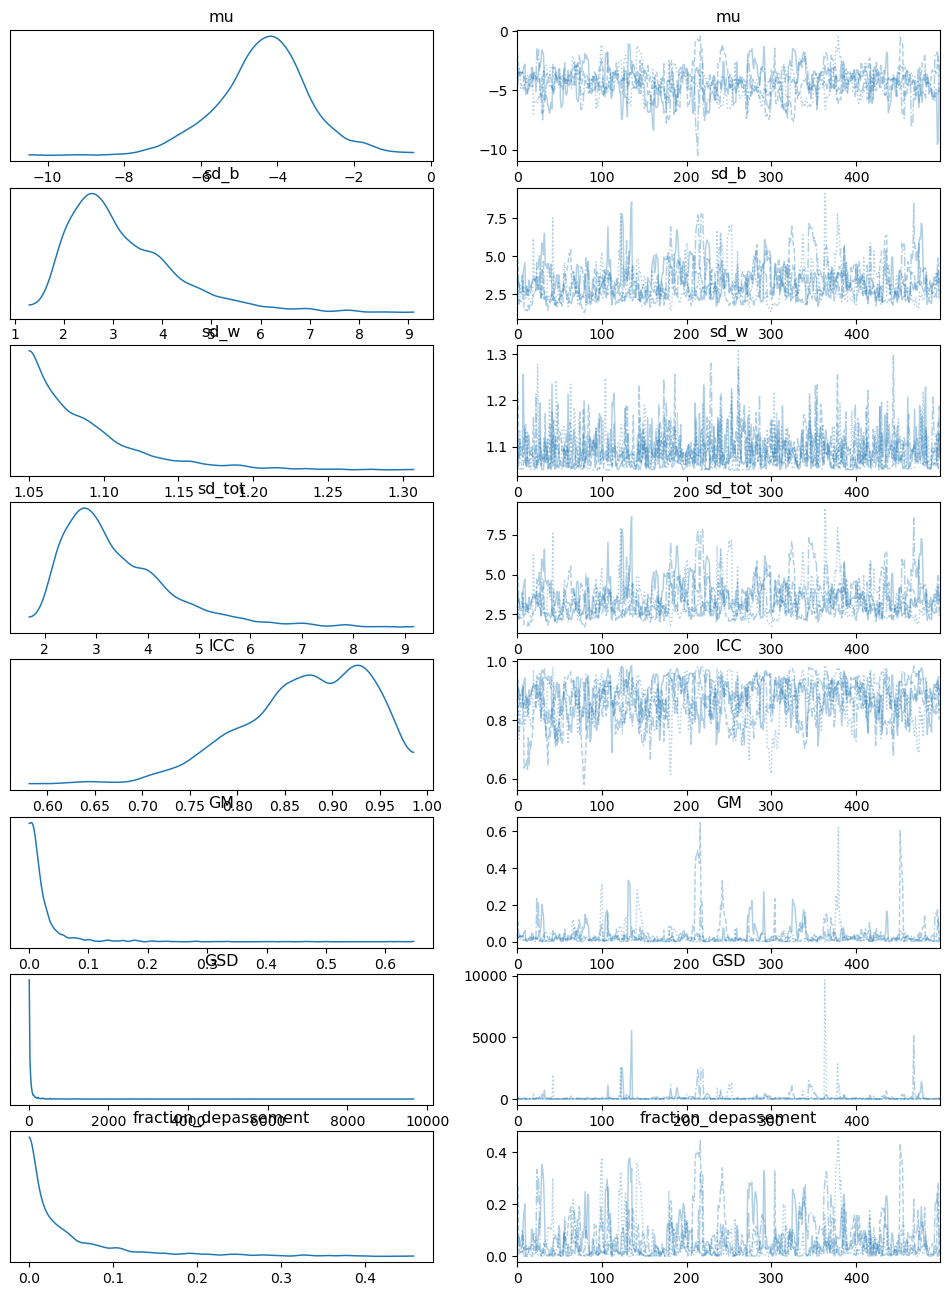

In [62]:
print(1-summary['fraction_depassement']['hdi_low50'])
print(1-summary['fraction_depassement']['hdi_high50'])
print()
print(summary['prob_fd_gt_lim'])
print(summary['mu']['median'])
print(summary['sd_tot']['median'])
print()

mu=summary['mu']['median']
sd=summary['sd_tot']['median']
pl=1-summary['fraction_depassement']['hdi_low50']
ph=1-summary['fraction_depassement']['hdi_high50']

print(percentile_deterministic(mu,sd,pl))
print(percentile_deterministic(mu,sd,ph))



az.plot_trace(idata, combined=True, var_names=["mu","sd_b","sd_w","sd_tot","ICC","GM","GSD","fraction_depassement"])
plt.show()

In [79]:
def prob_95th_above_vle(idata, VLE=1.0, p=0.95):
    mu = idata.posterior["mu"].values.flatten()
    sd_tot = idata.posterior["sd_tot"].values.flatten()
    
    # 95th percentile for each posterior draw
    q95 = np.exp(mu + norm.ppf(p) * sd_tot)
    
    # Probability that q95 > VLE
    prob = np.mean(q95 > VLE)
    print(prob )
    # Résumé (médiane et HDI du Q95)
    q95_median = np.median(q95)
    q95_hdi = az.hdi(q95, hdi_prob=0.95)

    print(q95_median)
prob_95th_above_vle(idata,58.5,0.97)

0.168
5.023016125348663


In [18]:
df_res0 = balayage_vle("dataNDL.csv", range(1,10,1),0.1)
df_res1 = balayage_vle("dataNDL.csv", range(1,10,1),1)
df_res10 = balayage_vle("dataNDL.csv", range(1,10,1),10)
df_res100 = balayage_vle("dataNDL.csv", range(1,10,1),100)

--- VLE = 0.1 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 0.2 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 0.30000000000000004 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 0.4 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 0.5 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 0.6000000000000001 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 0.7000000000000001 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 0.8 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 15 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 0.9 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 1 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 2 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 3 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 4 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 5 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 6 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 7 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 8 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 9 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 10 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 20 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 30 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 40 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 50 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 60 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 70 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 80 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 90 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 100 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 200 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 300 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 400 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 500 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 600 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 700 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 800 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


--- VLE = 900 ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd_b, sd_w, u]


Output()

Sampling 2 chains for 300 tune and 500 draw iterations (600 + 1_000 draws total) took 14 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [24]:
df_res = pd.concat([df_res0, df_res1, df_res10, df_res100])
df_res.to_csv('risque_par_VLE.csv', index=False)

In [9]:
df_res = pd.read_csv("risque_par_VLE.csv") 

In [12]:
def sigmoid(x, L, k, x0, b):
    """
    Sigmoid function
    L: curve's maximum value
    k: logistic growth rate (steepness)
    x0: x-value of the sigmoid's midpoint
    b: y-intercept adjustment
    """
    return L / (1 + np.exp(-k * (x - x0))) + b

def fit_sigmoid(target_y=0.3):     
    x_data = df_res["VLE"].values
    y_data = df_res["risque_surexposition"].values
    
    # Remove any NaN values
    mask = ~(np.isnan(x_data) | np.isnan(y_data))
    x_data = x_data[mask]
    y_data = y_data[mask]
    
    print(f"Clean data points: {len(x_data)}")
    print(f"X range: [{np.min(x_data):.3f}, {np.max(x_data):.3f}]")
    print(f"Y range: [{np.min(y_data):.3f}, {np.max(y_data):.3f}]")
    
    # Initial parameter guess
    L_guess = np.max(y_data) - np.min(y_data)  # Range of y values
    k_guess = 1.0  # Growth rate
    x0_guess = np.median(x_data)  # Midpoint
    b_guess = np.min(y_data)  # Minimum value
    
    initial_guess = [L_guess, k_guess, x0_guess, b_guess]
    print(f"Initial parameter guess: L={L_guess:.3f}, k={k_guess:.3f}, x0={x0_guess:.3f}, b={b_guess:.3f}")
    
    try:
        # Fit the sigmoid
        popt, pcov = curve_fit(sigmoid, x_data, y_data, p0=initial_guess, maxfev=10000)
        L_fit, k_fit, x0_fit, b_fit = popt
        
        # Calculate R-squared
        y_pred = sigmoid(x_data, *popt)
        ss_res = np.sum((y_data - y_pred) ** 2)
        ss_tot = np.sum((y_data - np.mean(y_data)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        print(f"\nFitted parameters:")
        print(f"L (maximum): {L_fit:.6f}")
        print(f"k (steepness): {k_fit:.6f}")
        print(f"x0 (midpoint): {x0_fit:.6f}")
        print(f"b (offset): {b_fit:.6f}")
        print(f"R-squared: {r_squared:.6f}")
        
        # Calculate parameter standard errors
        param_errors = np.sqrt(np.diag(pcov))
        print(f"\nParameter standard errors:")
        print(f"σ_L: ±{param_errors[0]:.6f}")
        print(f"σ_k: ±{param_errors[1]:.6f}")
        print(f"σ_x0: ±{param_errors[2]:.6f}")
        print(f"σ_b: ±{param_errors[3]:.6f}")
        
    except Exception as e:
        print(f"Error in curve fitting: {e}")
        return None, None, None
    
    # Find x value for target y (VLE point)
    def find_x_for_y(target):
        def equation(x):
            return sigmoid(x, *popt) - target
        
        # Try to find solution within the data range
        x_min, x_max = np.min(x_data), np.max(x_data)
        try:
            x_solution = fsolve(equation, x0_fit)[0]
            
            # Verify the solution is reasonable
            y_check = sigmoid(x_solution, *popt)
            if abs(y_check - target) < 1e-6:
                return x_solution
            else:
                print(f"Warning: Solution verification failed. Target: {target}, Got: {y_check}")
                return x_solution
        except:
            print(f"Could not find x value for y = {target}")
            return None
    
    x_vle = find_x_for_y(target_y)
    
    if x_vle is not None:
        print(f"\nVLE Analysis:")
        print(f"For y = {target_y}, x = {x_vle:.6f}")
        
        # Check if this is within or outside the data range
        if np.min(x_data) <= x_vle <= np.max(x_data):
            print("This x value is within the data range (interpolation)")
        else:
            print("This x value is outside the data range (extrapolation)")
    
    # Create plot
    plt.figure(figsize=(10, 6))
    
    # Plot original data
    plt.scatter(x_data, y_data, alpha=0.7, s=3, color='blue', label='Data points')
    plt.grid(which='both', color='lightgray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.xscale("log")
    
    # Plot fitted curve
    x_smooth = np.linspace(np.min(x_data) - 0.1*(np.max(x_data) - np.min(x_data)), 
                          np.max(x_data) + 0.1*(np.max(x_data) - np.min(x_data)), 300)
    y_smooth = sigmoid(x_smooth, *popt)
    plt.plot(x_smooth, y_smooth, 'r-', linewidth=1, 
             label=f'Sigmoid fit (R² = {r_squared:.4f})')
    
    # Mark VLE point if found
    if x_vle is not None:
        plt.axhline(y=target_y, xmin=0, xmax=x_vle, color='green', linestyle='--', alpha=0.7, lw=1)
        plt.axvline(x=x_vle, ymin=0, ymax=0.3, color='green', linestyle='--', alpha=0.7, lw=1)
        plt.plot(x_vle, target_y, 'go', markersize=3, 
                label=f'VLE point: x={x_vle:.4f}, y={target_y}')
    plt.ylim(0,1)
    plt.xlabel('VLE')
    plt.ylabel('Risque')
    plt.title('Sigmoid Fitting for VLE Analysis')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return popt, r_squared, x_vle

Sigmoid Fitting for VLE Analysis
Clean data points: 36
X range: [0.100, 900.000]
Y range: [0.054, 1.000]
Initial parameter guess: L=0.946, k=1.000, x0=9.500, b=0.054

Fitted parameters:
L (maximum): -2298.322470
k (steepness): 0.024864
x0 (midpoint): -313.852708
b (offset): 2298.404460
R-squared: 0.994564

Parameter standard errors:
σ_L: ±606634.942195
σ_k: ±0.001809
σ_x0: ±10637.897816
σ_b: ±606634.945260

VLE Analysis:
For y = 0.3, x = 58.694449
This x value is within the data range (interpolation)


C:\Users\guemfr1\AppData\Local\Temp\ipykernel_12572\2435715054.py:9: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0))) + b


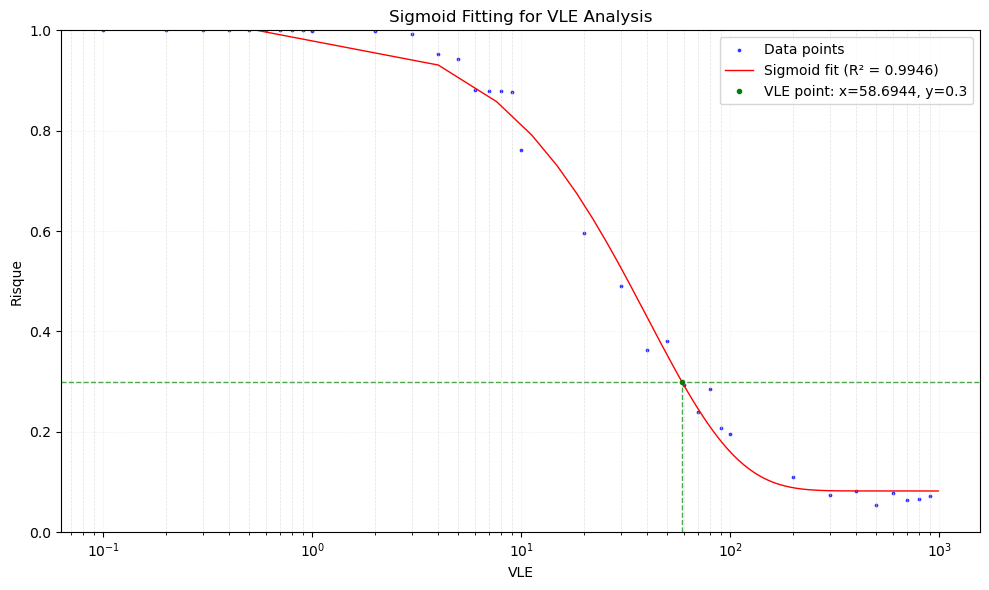


Sigmoid equation: y = -2298.3225 / (1 + exp(-0.0249 * (x - -313.8527))) + 2298.4045

VLE Result: At y = 0.3, x = 58.694449

Additional VLE points:
y = 0.1: x = 158.986102
y = 0.5: x = 32.510123
y = 0.7: x = 16.781193
y = 0.9: x = 5.501611


In [13]:
print("Sigmoid Fitting for VLE Analysis")
print("=" * 40)

# Fit sigmoid and find VLE point
params, r_squared, x_vle = fit_sigmoid(target_y=0.3)

if params is not None:
    L, k, x0, b = params
    print(f"\nSigmoid equation: y = {L:.4f} / (1 + exp(-{k:.4f} * (x - {x0:.4f}))) + {b:.4f}")
    
    if x_vle is not None:
        print(f"\nVLE Result: At y = 0.3, x = {x_vle:.6f}")
else:
    print("Fitting failed.")

# If you want to try different target y values:
other_targets = [0.1, 0.5, 0.7, 0.9]
if params is not None:
    print(f"\nAdditional VLE points:")
    for target in other_targets:
        def equation(x):
            return sigmoid(x, *params) - target
        try:
            x_target = fsolve(equation, params[2])[0]  # Use x0 as initial guess
            print(f"y = {target}: x = {x_target:.6f}")
        except:
            print(f"y = {target}: Could not find solution")